### Manipulating the training data on the fly
A really great feature in Lasagne is the ability to easily manipulate the training (and test-data) on the fly. This is often done in a random fashion by applying transformations under which the objects are invariant. All winners of competitions do a **clever** data augmentation. So let's give it a try... 

Note that this notebook is just to show you how the augmentation works from a programming standpoint. If you want to see the benefit of augmentation, have a look at [DataAugmentationII.ipynb](DataAugmentationII.ipynb) 


#### BatchIterator the point of entry
To augment the data on the fly one has to implement a  `BatchIterator` with our own transformation method. In the following we preform a very simple and crude transformation method, we simply flip the image on the y-axis. In principle using cv2 or other libraries quite complex operations are possible and used in practice.

#### Flipping
For the non-python freaks as me a short reminder that flipping can be done as follows:

In [1]:
a = (1,2,3,4)
a[::-1]

(4, 3, 2, 1)

#### Loading the data
As in the previous notebooks we define the network and load the data. 

In [1]:
#We load the net and the data from the last example
from lasagne import layers
from lasagne import nonlinearities
from nolearn.lasagne import NeuralNet
import cPickle as pickle
import gzip
with gzip.open('mnist_4000.pkl.gz', 'rb') as f:
    (X,y) = pickle.load(f)
PIXELS = len(X[0,0,0,:])
X.shape, y.shape, PIXELS

def createNet():
   return NeuralNet(
        # Geometry of the network
        layers=[
            ('input', layers.InputLayer),
            ('conv1', layers.Conv2DLayer),
            ('pool1', layers.MaxPool2DLayer),
            ('conv2', layers.Conv2DLayer),
            ('pool2', layers.MaxPool2DLayer),
            ('hidden4', layers.DenseLayer),
            ('output', layers.DenseLayer),
            ],
        input_shape=(None, 1, PIXELS, PIXELS), #None in the first axis indicates that the batch size can be set later
        conv1_num_filters=32, conv1_filter_size=(3, 3), pool1_pool_size=(2, 2), #pool_size used to be called ds in old versions of lasagne
        conv2_num_filters=64, conv2_filter_size=(2, 2), pool2_pool_size=(2, 2),
        hidden4_num_units=500,
        output_num_units=10, output_nonlinearity=nonlinearities.softmax,

        # learning rate parameters
        update_learning_rate=0.01,
        update_momentum=0.90,
        regression=False,
        # We only train for 10 epochs
        max_epochs=10,
        verbose=1,

        # Training test-set split
        eval_size = 0.2
        )

#### Fitting the network (no augmentation)
Fitting the model with the standard BatchIterator which does not do on the fly manipulations.

In [2]:
net1 = createNet()
d = net1.fit(X[0:1000,:,:,:],y[0:1000]); #Training with the 

  DenseLayer        	(None, 10)          	produces      10 outputs
  DenseLayer        	(None, 500)         	produces     500 outputs
  MaxPool2DLayer    	(None, 64, 6, 6)    	produces    2304 outputs
  Conv2DLayer       	(None, 64, 12, 12)  	produces    9216 outputs
  MaxPool2DLayer    	(None, 32, 13, 13)  	produces    5408 outputs
  Conv2DLayer       	(None, 32, 26, 26)  	produces   21632 outputs
  InputLayer        	(None, 1, 28, 28)   	produces     784 outputs

 Epoch  |  Train loss  |  Valid loss  |  Train / Val  |  Valid acc  |  Dur
--------|--------------|--------------|---------------|-------------|-------
     1  |    2.273287  |    2.175909  |     1.044753  |     42.11%  |  6.9s
     2  |    1.983694  |    1.815794  |     1.092467  |     49.69%  |  7.0s
     3  |    1.438780  |    1.172793  |     1.226798  |     62.91%  |  7.0s
     4  |    0.854319  |    0.802410  |     1.064692  |     76.42%  |  7.1s
     5  |    0.541192  |    0.684301  |     0.790869  |     82.05%  |  7.2

/Library/Python/2.7/site-packages/lasagne/init.py:86: UserWarning: The uniform initializer no longer uses Glorot et al.'s approach to determine the bounds, but defaults to the range (-0.01, 0.01) instead. Please use the new GlorotUniform initializer to get the old behavior. GlorotUniform is now the default for all layers.
  warnings.warn("The uniform initializer no longer uses Glorot et al.'s "
/Library/Python/2.7/site-packages/lasagne/layers/helper.py:69: UserWarning: get_all_layers() has been changed to return layers in topological order. The former implementation is still available as get_all_layers_old(), but will be removed before the first release of Lasagne. To ignore this warning, use `warnings.filterwarnings('ignore', '.*topo.*')`.
  warnings.warn("get_all_layers() has been changed to return layers in "
/Library/Python/2.7/site-packages/lasagne/layers/base.py:99: UserWarning: layer.get_output_shape() is deprecated and will be removed for the first release of Lasagne. Please us

#### Custom BatchIterator
Now we create our own BatchIterator which does the flipping around the x-axis.

In [3]:
from nolearn.lasagne import BatchIterator

class SimpleBatchIterator(BatchIterator):

    def transform(self, Xb, yb):
        # The 'incomming' and outcomming shape is (10, 1, 28, 28)
        Xb, yb = super(SimpleBatchIterator, self).transform(Xb, yb)
        return Xb[:,:,:,::-1], yb #<--- Here we do the flipping of the images

# Setting the new batch iterator
net1.batch_iterator_train = SimpleBatchIterator(batch_size=10)
d = net1.fit(X[0:1000,:,:,:],y[0:1000])


  DenseLayer        	(None, 10)          	produces      10 outputs
  DenseLayer        	(None, 500)         	produces     500 outputs
  MaxPool2DLayer    	(None, 64, 6, 6)    	produces    2304 outputs
  Conv2DLayer       	(None, 64, 12, 12)  	produces    9216 outputs
  MaxPool2DLayer    	(None, 32, 13, 13)  	produces    5408 outputs
  Conv2DLayer       	(None, 32, 26, 26)  	produces   21632 outputs
  InputLayer        	(None, 1, 28, 28)   	produces     784 outputs

 Epoch  |  Train loss  |  Valid loss  |  Train / Val  |  Valid acc  |  Dur
--------|--------------|--------------|---------------|-------------|-------
     1  |    1.187332  |    1.545440  |     0.768281  |     48.83%  |  7.4s
     2  |    0.233399  |    2.098233  |     0.111236  |     44.24%  |  7.4s
     3  |    0.089768  |    2.770103  |     0.032406  |     43.32%  |  7.3s
     4  |    0.026483  |    3.479021  |     0.007612  |     36.92%  |  7.3s
     5  |    0.016780  |    3.645117  |     0.004603  |     42.27%  |  7.5

We see that it takes a bit longer (0.4 sec), which is strange since in theory the flipping should be done on the CPU while the GPU is busy doing the fitting. Maybe the network is not big enough to keep the GPU busy? Anyway.

The second observation is that the performance drops from approx. 80% to approx. 40%. The reason may be that it’s not such a good idea to flip the training data in the first place. Any idea why?

#### Visualization of some augmented training examples

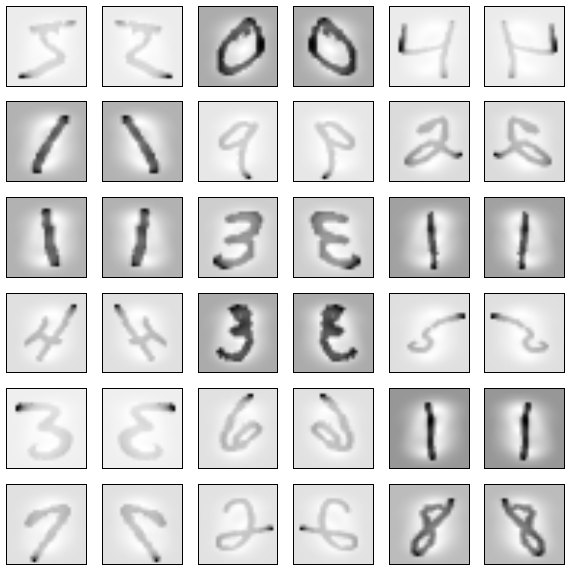

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as imgplot
fig = plt.figure(figsize=(10,10))
for i in range(18):
    a=fig.add_subplot(6,6,2*i+1,xticks=[], yticks=[])
    plt.imshow(-X[i,0,:,:], cmap=plt.get_cmap('gray'))
    a=fig.add_subplot(6,6,2*i+2,xticks=[], yticks=[])
    plt.imshow(-X[i,0,:,::-1], cmap=plt.get_cmap('gray'))


**Maybe we should do a more clever data augmentation next time**: Have a look at [DataAugmentationII.ipynb](DataAugmentationII.ipynb)

#### More control
If overwritting the `transform` method is not sufficient, one might even overwrite the `__iter__` method in the BatchIterator.